In [47]:
import xarray as xr
import pandas as pd
import numpy as np
from scipy import interpolate
import glob
import os
import matplotlib.pyplot as plt
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyxpcm import pcm

yeart='201*'
montht='*'

ROOT='/home5/pharos/REFERENCE_DATA/OCEAN_REP/CORA/CORA5.1/data/'
path=glob.glob(os.path.join(ROOT+yeart+'/*'+yeart+montht+'15_dat_TEMP.nc'))
path.sort()
DAT=xr.open_mfdataset(path,decode_times=False)
DAT=DAT.where((DAT.LATITUDE>=28)&(DAT.LATITUDE<=45)&(DAT.LONGITUDE>=-79)&(DAT.LONGITUDE<=-35),drop=True)
print len(DAT.N_PROF.values),'profiles'

284025 profiles


In [48]:
#REDUCE TO QC=1
mask = (np.abs(DAT['TEMP']) != np.nan) & (DAT['TEMP_QC'] == 1.)
DAT.coords['mask'] = (('N_PROF', 'N_LEVELS'), mask)
DAT = DAT.where(DAT.mask, drop=True)
DAT = DAT.drop('mask')

#AT LEAST 10 POINTS ON PROFILE WITH MIN DEPTH =< 5m & MAX DEPHT >= 700m
H = DAT['DEPH'].where(DAT['TEMP'].notnull()).max(dim='N_LEVELS')
G = DAT['DEPH'].where(DAT['TEMP'].notnull()).min(dim='N_LEVELS')
DAT = DAT.where((H>=700)&(G<=5),drop=True)
N = DAT['TEMP'].notnull().sum('N_LEVELS')
DAT = DAT.where(N>=10,drop=True) 

print len(DAT.N_PROF.values),'profiles'

58211 profiles


In [49]:
#REDUCE DIMENSIONS
DAT['A']=DAT['REFERENCE_DATE_TIME'].min(dim='N_LEVELS')
DAT['B']=DAT['DATA_TYPE'].min(dim='N_LEVELS')
DAT['C']=DAT['PLATFORM_NUMBER'].min(dim='N_LEVELS')
DAT['D']=DAT['WMO_INST_TYPE'].min(dim='N_LEVELS')
DAT['E']=DAT['DC_REFERENCE'].min(dim='N_LEVELS')
DAT['F']=DAT['JULD'].min(dim='N_LEVELS')
DAT['G']=DAT['LATITUDE'].min(dim='N_LEVELS')
DAT['H']=DAT['LONGITUDE'].min(dim='N_LEVELS')
DAT['I']=DAT['TEMP_PROC'].min(dim='N_LEVELS')
DAT=DAT.drop(['REFERENCE_DATE_TIME','DATA_TYPE','PLATFORM_NUMBER','WMO_INST_TYPE','DC_REFERENCE',
             'JULD','LATITUDE','LONGITUDE','TEMP_PROC'])
DAT=DAT.rename({'A':'REFERENCE_DATE_TIME','B':'DATA_TYPE','C':'PLATFORM_NUMBER',
                'D':'WMO_INST_TYPE','E':'DC_REFERENCE','F':'JULD','G':'LATITUDE',
                'H':'LONGITUDE','I':'TEMP_PROC'})

In [50]:
#INTERPOLATION
#first create the interpolation model between N_LEVELS and DEPH
xx=DAT.DEPH.min(dim='N_PROF').values
yy=range(len(DAT.N_LEVELS))
ft=interpolate.interp1d(xx,yy,bounds_error=False,fill_value='extrapolate')
#now generate the new levels to interpolate on (0m to 500m)
new_depth=np.arange(0,500,5)
iy=ft(new_depth)
#pre-interpolate NaN values on original depth values
filledT=DAT.TEMP.interpolate_na(dim='N_LEVELS')
#Duplicate 1st value (at 5m or below) to surface
filledT.load()
filledT[:,0:3]=filledT[:,0:3].bfill(dim='N_LEVELS')    
#xarray interpolate profiles
TEMPi=filledT.interp(N_LEVELS=iy)
TEMPi.load()
TEMPi[:,0:3]=TEMPi[:,0:3].bfill(dim='N_LEVELS')  

#create new dataset
new_ds=xr.Dataset({'temp':(['N_PROF','DEPTH'],TEMPi.values),
                   'latitude':(['N_PROF'],DAT.LATITUDE.values),
                   'longitude':(['N_PROF'],DAT.LONGITUDE.values),
                   'juld':(['N_PROF'],DAT.JULD.values)},
                  coords={'DEPTH':new_depth})        

#CREATE DATE FROM JULD
import datetime
def f(x):    
    date_1 = datetime.datetime.strptime('01/01/1950', "%m/%d/%Y")
    return date_1 + datetime.timedelta(days=x)

new_ds['date']=xr.DataArray(np.array([f(xi) for xi in new_ds.juld.values]),dims='N_PROF')
dates=pd.DatetimeIndex(new_ds.date.values)
new_ds['months']=xr.DataArray(np.array(dates.month,dtype='int'),dims='N_PROF')

print new_ds

<xarray.Dataset>
Dimensions:    (DEPTH: 100, N_PROF: 58211)
Coordinates:
  * DEPTH      (DEPTH) int64 0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 ...
Dimensions without coordinates: N_PROF
Data variables:
    latitude   (N_PROF) float64 39.05 40.33 32.62 34.6 39.93 28.74 37.3 32.1 ...
    longitude  (N_PROF) float64 -35.71 -37.28 -57.88 -61.25 -47.54 -38.94 ...
    temp       (N_PROF, DEPTH) float64 16.89 16.89 16.9 16.9 16.9 16.9 16.9 ...
    juld       (N_PROF) float64 2.189e+04 2.189e+04 2.189e+04 2.189e+04 ...
    date       (N_PROF) datetime64[ns] 2009-12-09T11:09:02 ...
    months     (N_PROF) int64 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 ...


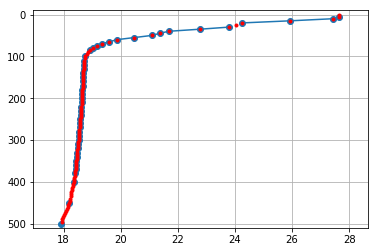

In [57]:
%matplotlib inline
idx=25005
plt.figure()
plt.plot(DAT.TEMP[idx,:],DAT.DEPH[idx,:],'-o')
plt.plot(new_ds.temp[idx,:],new_ds.DEPTH,'r.')
plt.ylim(-10,510)
plt.xlim(new_ds.temp[idx,:].min()-1,new_ds.temp[idx,:].max()+1)
plt.gca().invert_yaxis()
plt.grid()

In [58]:
# From this new dataset, create a more uniform subset to train PCM
# 10 random profiles per 1/2° x 1/2° grid cell

gx=np.arange(-79,-35,0.5)
gy=np.arange(28,45,0.5)
sub_temp=np.empty([0,len(new_depth)])
sub_lat=np.empty([0])
sub_lon=np.empty([0])
sub_jul=np.empty([0])

for i in gx:
    for j in gy:
        sub_ds=new_ds.where((new_ds.longitude>=i)&(new_ds.longitude<i+0.5)&(new_ds.latitude>=j)&
                           (new_ds.latitude<j+0.5),drop=True)
        if(len(sub_ds.N_PROF)>=10):
            #RANDOM 10
            sel=np.random.choice(range(len(sub_ds.N_PROF)),10,False)
            sub_temp=np.vstack((sub_temp,sub_ds.temp[sel,:].values))
            sub_lat=np.append(sub_lat,sub_ds.latitude[sel].values)
            sub_lon=np.append(sub_lon,sub_ds.longitude[sel].values)           
            sub_jul=np.append(sub_jul,sub_ds.juld[sel].values)  
        else:
            #ALL PROFILES
            sel=sub_ds.N_PROF.values
            sub_temp=np.vstack((sub_temp,sub_ds.temp[sel,:].values))
            sub_lat=np.append(sub_lat,sub_ds.latitude[sel].values)
            sub_lon=np.append(sub_lon,sub_ds.longitude[sel].values)           
            sub_jul=np.append(sub_jul,sub_ds.juld[sel].values)  
            
#new dataset
train_ds=xr.Dataset({'temp':(['N_PROF','DEPTH'],sub_temp),
                   'latitude':(['N_PROF'],sub_lat),
                   'longitude':(['N_PROF'],sub_lon),
                   'juld':(['N_PROF'],sub_jul)},
                  coords={'DEPTH':new_depth})        
print train_ds
        

<xarray.Dataset>
Dimensions:    (DEPTH: 100, N_PROF: 23818)
Coordinates:
  * DEPTH      (DEPTH) int64 0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 ...
Dimensions without coordinates: N_PROF
Data variables:
    latitude   (N_PROF) float64 28.36 28.18 28.14 28.3 28.3 28.14 28.3 28.19 ...
    longitude  (N_PROF) float64 -78.56 -78.88 -78.85 -78.92 -78.92 -78.85 ...
    temp       (N_PROF, DEPTH) float64 25.27 25.27 25.24 25.22 25.18 25.15 ...
    juld       (N_PROF) float64 2.384e+04 2.406e+04 2.339e+04 2.339e+04 ...


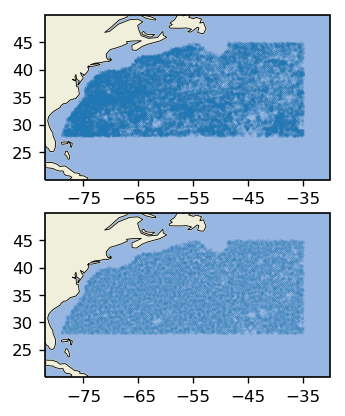

In [59]:
fig = plt.figure(dpi=120)
mproj=ccrs.PlateCarree()

ax = fig.add_subplot(2, 1, 1, projection=mproj)
ax.set_extent([-82, -30, 20, 50], crs=mproj)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.set_xticks(range(-75,-30,10), crs=mproj)
ax.set_yticks(range(25,50,5), crs=mproj)
ax.plot(new_ds.longitude,new_ds.latitude,'.',markersize=0.1)

az = fig.add_subplot(2, 1, 2, projection=mproj)
az.set_extent([-82, -30, 20, 50], crs=mproj)
az.add_feature(cfeature.OCEAN)
az.add_feature(cfeature.LAND)
az.add_feature(cfeature.COASTLINE, linewidth=0.5)
az.set_xticks(range(-75,-30,10), crs=mproj)
az.set_yticks(range(25,50,5), crs=mproj)
az.plot(train_ds.longitude,train_ds.latitude,'.',markersize=0.1)

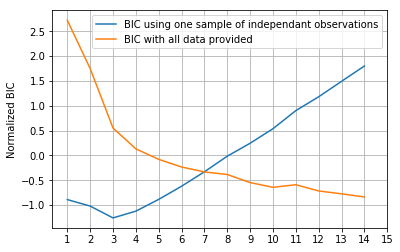

In [60]:
from pyxpcm import pcm

#BIC SIMULATION TO DECIDE HOW MANY CLUSTERS WE USE
kmax = 15
BIC = np.zeros((kmax-1))
BICr = np.zeros((kmax-1))
#Number of independant points : Surface of the quadrangle / surface of a circle r=150km (argo corelation radius)
Sg=(6370**2)*(79-35)*(np.pi/180)*(np.sin(45)-np.sin(28))
Cg=2*np.pi*(150**2)
n=int(np.round(Sg/Cg))

for k in range(1,kmax):
    m = pcm(K=k, feature_axis=np.arange(0,500,5), feature_name='temperature')
    A=m.fit(train_ds, feature={'temperature': 'temp'})
    llih=m.score(train_ds, feature={'temperature': 'temp'})
    Xn=m.preprocessing(train_ds,feature={'temperature':'temp'})
    #D=Dimension de la decomposition verticale des profiles (EOF)
    D = Xn.shape[1]
    Nf = (k+1)-1 + (k+1)*D + (k+1)*D*(D+1)/2
    BIC[k-1] = -2*n*llih + Nf*np.log(n) #    
    BICr[k-1]=m._classifier.bic(Xn)
    
plt.figure()
plt.plot(np.arange(kmax-1)+1,(BIC-np.mean(BIC))/np.std(BIC), label='BIC using one sample of independant observations')
plt.plot(np.arange(kmax-1)+1,(BICr-np.mean(BICr))/np.std(BICr), label='BIC with all data provided')
plt.ylabel('Normalized BIC')
plt.xticks(np.arange(kmax)+1)
plt.grid()
plt.legend()    

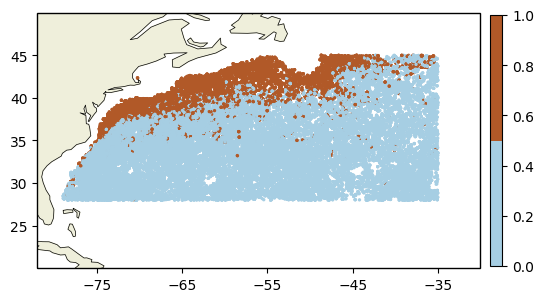

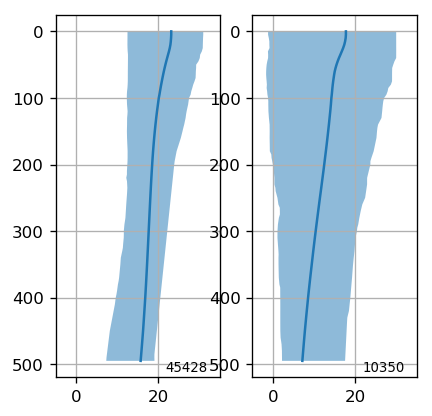

In [62]:
#SO WE CHOOSE N CLUSTERS TO CLASSIFY ALL PROFILES
Knum=2
m = pcm(K=Knum, feature_axis=np.arange(0,500,5), feature_name='temperature')
m.fit(train_ds, feature={'temperature': 'temp'})
LABELS=m.predict(new_ds, feature={'temperature': 'temp'})
POSTS=m.predict_proba(new_ds, feature={'temperature': 'temp'})

%matplotlib inline
#PLOT CLUSTERS
ccm = cm.get_cmap('Paired', Knum)
fig = plt.figure(dpi=100)
mproj=ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=mproj)
ax.set_extent([-82, -30, 20, 50], crs=mproj)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.set_xticks(range(-75,-30,10), crs=mproj)
ax.set_yticks(range(25,50,5), crs=mproj)
idp=(POSTS.max(dim='N_CLASS')>0.95)
sc=ax.scatter(new_ds.longitude[idp],new_ds.latitude[idp],s=2,alpha=1,c=LABELS[idp],cmap=ccm)
plt.colorbar(sc, fraction=0.027, pad=0.02)

plt.figure(dpi=120)
for i in range(Knum):
    plt.subplot(np.floor((Knum-1)/3)+1,3,i+1)
    if(len(new_ds.temp.where((LABELS==i)&(POSTS.max(dim='N_CLASS')>0.95),drop=True).N_PROF)>0):        
        plt.plot(new_ds.temp.where((LABELS==i)&(POSTS.max(dim='N_CLASS')>0.95),drop=True).mean(dim='N_PROF').values,new_depth)    
        minv=new_ds.temp.where((LABELS==i)&(POSTS.max(dim='N_CLASS')>0.95),drop=True).min(dim='N_PROF').values
        maxv=new_ds.temp.where((LABELS==i)&(POSTS.max(dim='N_CLASS')>0.95),drop=True).max(dim='N_PROF').values
        plt.fill_betweenx(new_depth,minv,maxv,alpha=0.5)    
        plt.xlim(-5,35)
        plt.gca().invert_yaxis()
        plt.grid()
        plt.title(str(len(new_ds.temp.where((LABELS==i)&(POSTS.max(dim='N_CLASS')>0.95),drop=True).N_PROF.values)),x=0.8,y=-0.01,fontsize=8)

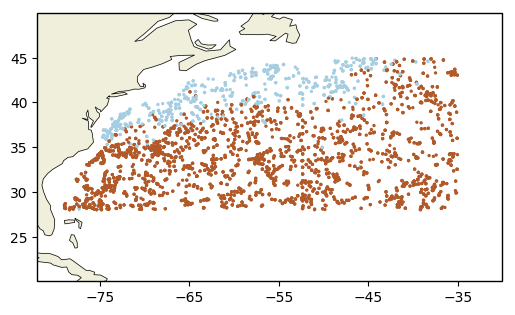

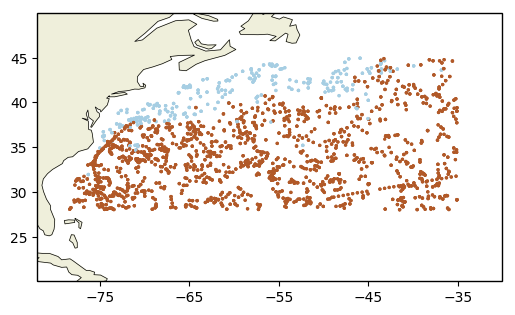

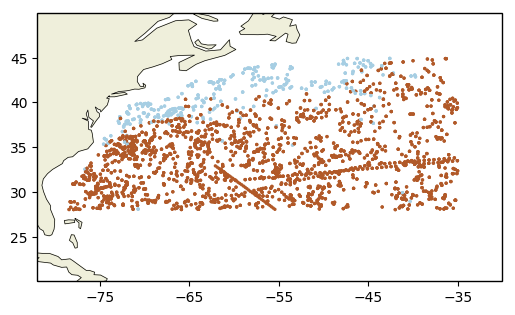

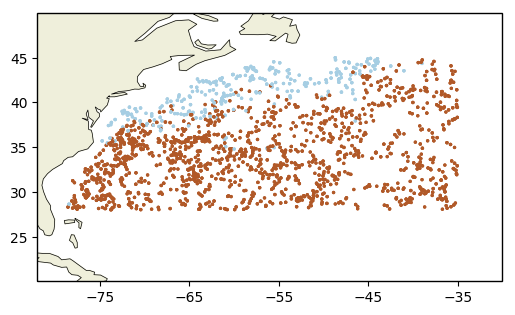

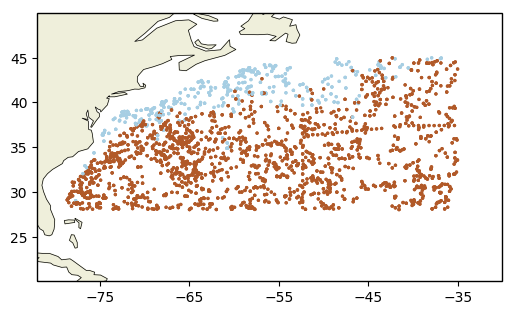

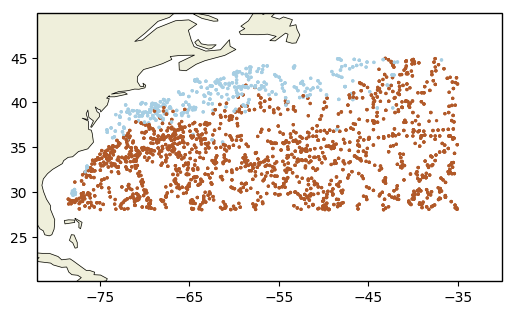

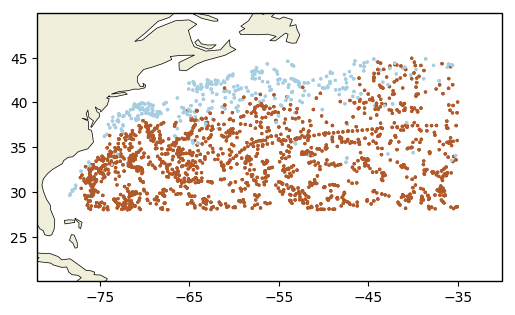

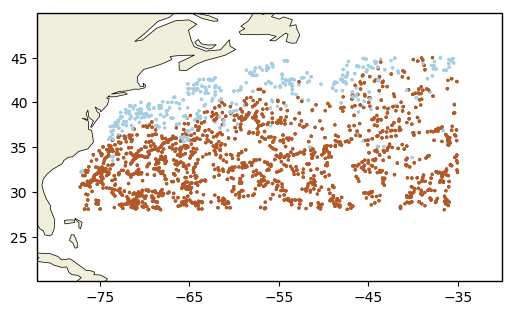

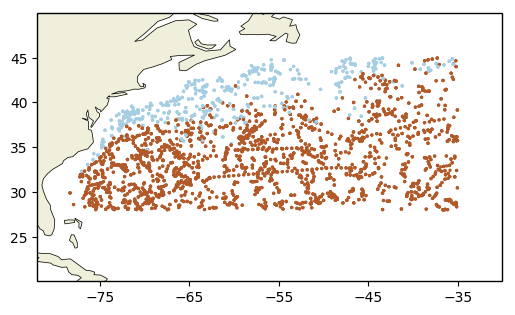

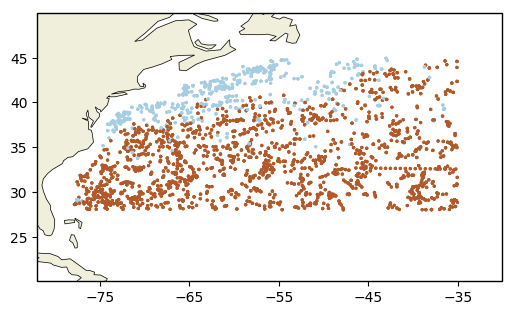

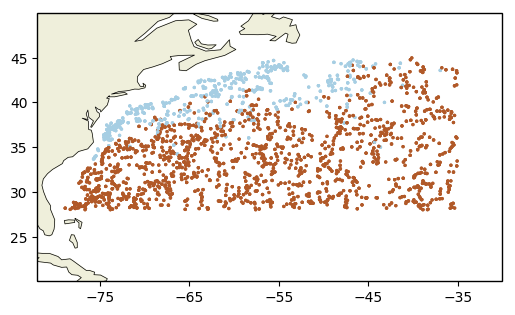

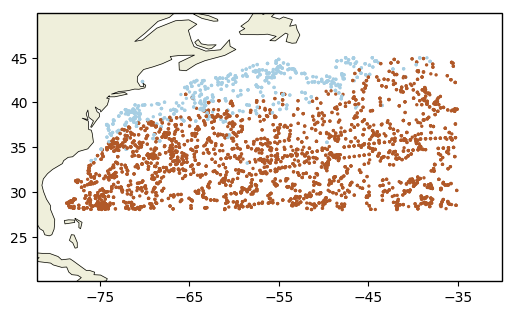

In [63]:
#Create classif model
Knum=2
m = pcm(K=Knum, feature_axis=np.arange(0,500,5), feature_name='temperature')
m.fit(train_ds, feature={'temperature': 'temp'})

%matplotlib inline
for month in np.arange(1,13):    
    #monthly profile selection
    sicds=new_ds.where(new_ds.months==month,drop=True)
    #classify    
    LABELS=m.predict(sicds, feature={'temperature': 'temp'})
    POSTS=m.predict_proba(sicds, feature={'temperature': 'temp'})
    #plot
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(1, 1, 1, projection=mproj)
    ax.set_extent([-82, -30, 20, 50], crs=mproj)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.set_xticks(range(-75,-30,10), crs=mproj)
    ax.set_yticks(range(25,50,5), crs=mproj)
    idp=(POSTS.max(dim='N_CLASS')>0.95)
    sc=ax.scatter(sicds.longitude[idp],sicds.latitude[idp],s=2,alpha=1,c=LABELS[idp],cmap=ccm)
